---
# 10.6 Chebyshev interpolation
---

We start with a motivating example.

## Exercise

Use the following code to visually determine, for each function,

- $f(x) = \sin(2 \pi x)$

- $f(x) = \frac{1}{1+25x^2}$

- $f(x) = \cos(x)$

the minimum number of evenly spaced interpolation points $x_0,\ldots,x_n$ necessary to obtain an accurate approximation. Keep increasing $n$ until the graphs of the function $f$ and the polynomial appear to coincide.

In [1]:
# Given the vector x = [x_0, ..., x_n], return the barycentric 
# weights of the Lagrange interpolating polynomial.
function lagrangeweights(x::Vector{T}) where T<:Union{AbstractFloat,Rational}

    n = length(x) - 1
    
    w = ones(T, length(x))  # An array of ones, the same size and type as x
    for j=1:n+1
        for i=1:n+1
            if i ≠ j
                w[j] *= (x[j] - x[i]) 
            end
        end
        w[j] = 1/w[j] 
    end
    
    return w
end

lagrangeweights (generic function with 1 method)

In [2]:
# Evaluates the Lagrange polynomial at the x-values in xspan.
# The Lagrange polynomial is given by the vectors w, x, and y.
function lagrangeeval(xspan::AbstractVector, w::Vector, x::AbstractVector, y::Vector)
    
    n = length(x)
    
    top = zero(xspan)
    bottom = zero(xspan)
    exact = zeros(Int, length(xspan))

    for j=1:n
        xdiff = xspan .- x[j]
        temp = w[j]./xdiff
        top += temp*y[j]
        bottom += temp
        
        exact[xdiff .== 0.0] .= j  # exact[i] = j if xspan[i] = x[j]
    end
    
    p = top./bottom

    iinds = findall(exact .!= 0)  # gives the indices i of xspan that equal some x[j]
    jinds = exact[iinds]          # gives the corresponding j indices
    p[iinds] = y[jinds]           # sets any NaNs in p to the correct values from y
    
    return p  
end

lagrangeeval(xx::Real, w::Vector, x::AbstractVector, y::Vector) = lagrangeeval([xx], w, x, y)[1]

lagrangeeval (generic function with 2 methods)

In [94]:
using Plots, LaTeXStrings

function myplot(f, n; cheb=false)
        
    # Compute the interpolation points
    if cheb
        xd = Float64[cos(π*(2i+1)/(2n+2)) for i=0:n]
    else
        xd = collect(range(-1, 1, length=n+1))
    end
        
    yd = map(f, xd)
    
    # Compute the interpolating polynomial
    w = lagrangeweights(xd)
    p(x) = lagrangeeval(x, w, xd, yd)
    
    plot()
    plot!(f, -1, 1, label=L"f(x)")
    plot!(p, -1, 1, label=L"p_n(x)")
    scatter!(xd, yd, label=:none)
end

myplot (generic function with 1 method)

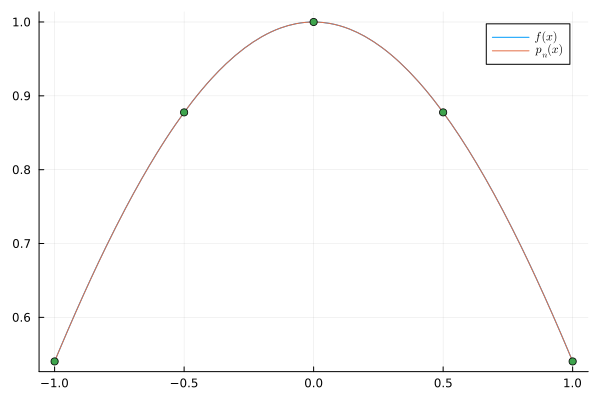

In [8]:
myplot(cos, 4)

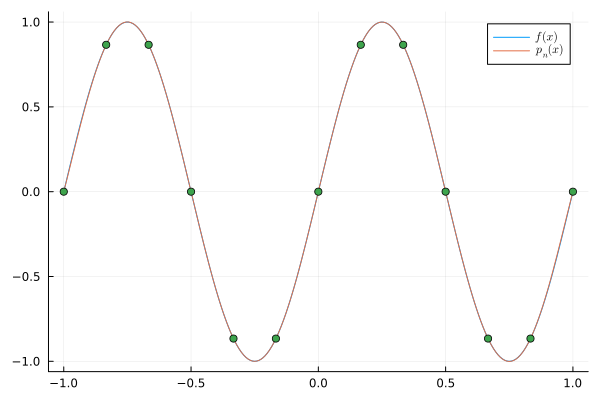

In [25]:
myplot(x -> sin(2π*x), 12)

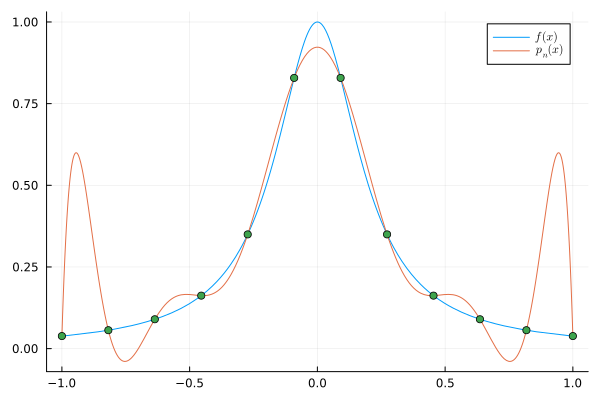

In [49]:
myplot(x -> 1/(1 + 25x^2), 11)

---

## Improving the approximation

- We know by **Weierstrass' Theorem** that we can approximate any function as close as we like using polynomials.

- However, using evenly spaced points does not work for the function $f(x) = \frac{1}{1+25x^2}$ over the interval $[-1,1]$.

- The error bound 
  
    $$\max_{x \in [a,b]} \left|f(x) - p_n(x)\right| \leq \frac{\left\|f^{(n+1)}\right\|}{(n+1)!} \max_{x \in [a,b]} \left|\prod_{i=0}^n (x-x_i)\right|$$
  
    suggests that we should choose the set of points $x_0,\ldots,x_n$ that **minimizes**
  
    $$\max_{x \in [a,b]} \left|\prod_{i=0}^n (x-x_i)\right|.$$
  
- Thus, we seek the roots of the **monic polynomial** 

    $$\phi_{n+1}(x) = \prod_{i=0}^n (x-x_i) = (x-x_0)\cdots(x-x_n)$$
  
    whose maximum absolute value over $[a,b]$ is minimized. 
  

- For now, we will restrict ourselves to the interval $[a,b] = [-1,1]$.
  
- We will see in **Chapter 12** that the monic polynomials that achieve the minimum max-absolute-value over $[-1,1]$ are the **monic Chebyshev polynomials**:

    $$
    \begin{align}
    \tilde T_0(x) &= 1 \\
    \tilde T_1(x) &= x \\
    \tilde T_2(x) &= x^2 - \frac12 \\
    \tilde T_3(x) &= x^3 - \frac34x \\
    \tilde T_4(x) &= x^4 - x^2 + \frac18 \\
    &\vdots\\
    \tilde T_{n+1}(x) &= x \tilde T_{n}(x) - \frac{1}{2^{n}} \tilde T_{n-1}(x)\\
    \end{align}
    $$

- The **monic Chebyshev polynomials** can also be written as

    $$\tilde T_{n+1}(x) = \frac{1}{2^{n}}\cos((n+1) \arccos(x))$$
  

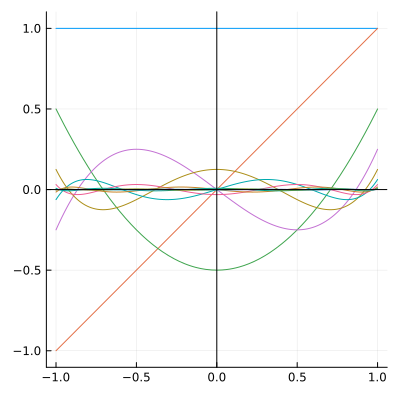

In [51]:
plot(legend=:none, aspect_ratio=:equal, size=(400,400))
plot!(x -> 1, -1, 1)
for n=0:10
    plot!(x -> cos((n+1)*acos(x))/2^n, -1, 1)
end
hline!([0], c=:black)
vline!([0], c=:black)

- Note that

    $$\max_{x \in [-1,1]} \left| \tilde T_{n+1}(x) \right| = \frac{1}{2^n}.$$

- The roots of $\tilde T_{n+1}$ are called the **Chebyshev points** and are given by

    $$x_i = \cos\left(\frac{2i+1}{2(n+1)}\pi\right), \quad i = 0,\ldots,n.$$
    
- We can shift these points to another interval $[a,b]$ using 

    $$x_i \gets a + \frac{b-a}{2}(x_i + 1), \quad i = 0,\ldots,n.$$
    
- Using the **Chebyshev points**, we obtain the error bound:

    $$\max_{x \in [-1,1]} \left|f(x) - p_n(x)\right| \leq \frac{\left\|f^{(n+1)}\right\|}{2^n(n+1)!}$$


---

## Exercise

Use the following code to visually determine, for each function,

- $f(x) = \sin(2\pi x)$
- $f(x) = \frac{1}{1+25x^2}$
- $f(x) = \cos(x)$

the minimum number of Chebyshev interpolation points $x_0,\ldots,x_n$ necessary to obtain an accurate approximation. Keep increasing $n$ until the graphs of the function $f$ and the polynomial appear to coincide.

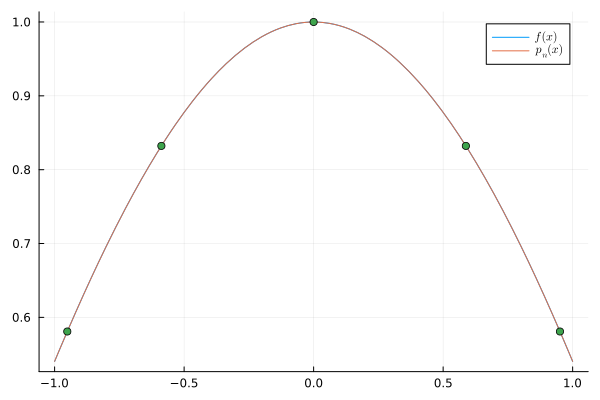

In [56]:
myplot(cos, 4, cheb=true)

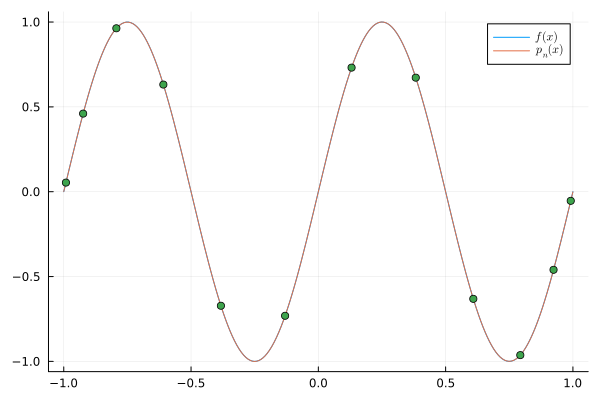

In [69]:
myplot(x -> sin(2π*x), 11, cheb=true)

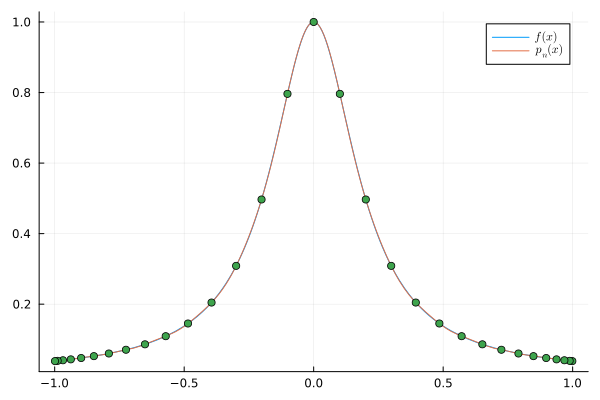

In [95]:
myplot(x -> 1/(1 + 25x^2), 30, cheb=true)

---